In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy

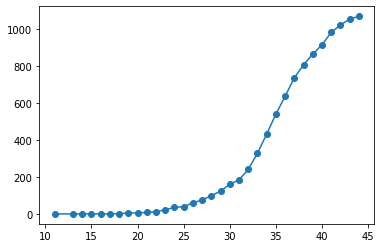

In [2]:
raw_data = [1,1,1,1,1,1,3,5,7,9,12,24,36,40,61,76,100,124,161,185,241,329,432,540,636,736,806,864,914,981,1021,1052,1068]
raw_time = [11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44]

start = 0
clip = None

data = raw_data[start:clip]
time = raw_time[start:clip]

def system_2(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y),
        p[1]*y[0]*y[2]/sum(y) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2]
    ]
plt.plot(time, data, 'o-')

In [3]:
data_pd = np.array([[i] for i in data])
p0 = [7./8, 15, 7./8]
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": {
        "state": 4,
        "parameters": 3
    },
    "time_span": [time[0], time[-1]],
    "knot_function": None,
    "model": system_2,
    "dataset": {"y": data_pd, "t": np.array(time)},
    "observation_vector": [-1],
    "weightings":[
        [1]*4,
        [1]*len(time)
    ],
    "regularisation_value": copy(p0),
}

In [4]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

In [49]:
solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(model.cs),
    'p': ca.hcat([*model.ps, objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, {'ipopt': {'print_level': 1}})

In [50]:
c0 = [np.ones(config['basis_number']) for _ in range(4)]
x0 = np.hstack(c0)

In [51]:
pure_solve = solver(x0=x0, p=[*p0, 0, 0], lbg=0)

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.35ms ( 79.18us)   1.35ms ( 79.12us)        17
       nlp_g  | 322.00us ( 18.94us) 319.56us ( 18.80us)        17
    nlp_grad  | 316.00us (316.00us) 315.87us (315.87us)         1
  nlp_grad_f  |   4.19ms (232.50us)   4.19ms (232.82us)        18
  nlp_hess_l  | 265.55ms ( 16.60ms) 264.99ms ( 16.56ms)        16
   nlp_jac_g  |   1.75ms ( 97.33us)   1.73ms ( 96.33us)        18
       total  | 319.13ms (319.13ms) 318.30ms (318.30ms)         1


In [52]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)

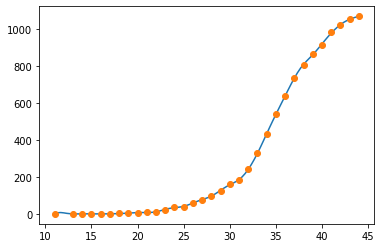

In [53]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(time, data, 'o')

In [54]:
fouter = ca.substitute(objective.objective, solver_setup['x'], solver(x0=x0,p=solver_setup['p'])['x'])

In [55]:
ps = ca.vcat(model.ps)
grad_raw = (ca.gradient(objective.objective, ps) - 
            ca.solve(ca.jacobian(ca.gradient(objective.objective,solver_setup['x']), solver_setup['x']), 
                     ca.jacobian(ca.gradient(objective.objective,solver_setup['x']),ps)).T
            @ ca.gradient(objective.objective, solver_setup['x']))
grad = ca.substitute(grad_raw, solver_setup['x'], solver(x0=x0,p=solver_setup['p'])['x'])
gg = ca.Function('gg', [ps, ca.hcat([objective.rho, objective.alpha])], [fouter, grad])

In [56]:
outer_opts = {
    'x' : ps,
    'f' : fouter,
    'p' : ca.hcat([objective.rho, objective.alpha]),
}

other_opts_lim = {
    'no_nlp_grad': True,
    'calc_lam_p': False,
    'grad_f': gg,
    'ipopt':{
        'hessian_approximation':'limited-memory',   # approximate the hessian
        'print_level': 5,
    },
    'verbose_init': True
}
sout_lim = ca.nlpsol('sout_l', 'ipopt', outer_opts, other_opts_lim)

In [63]:
sout_lim(x0=p0, p=[1e-6,1e2])

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.70ms ( 71.13us)   2.71ms ( 71.36us)        38
       nlp_g  | 625.00us ( 16.45us) 622.83us ( 16.39us)        38
    nlp_grad  | 314.00us (314.00us) 313.98us (313.98us)         1
  nlp_grad_f  |   6.64ms (189.57us)   6.64ms (189.73us)        35
  nlp_hess_l  | 532.13ms ( 16.13ms) 530.69ms ( 16.08ms)        33
   nlp_jac_g  |   2.78ms ( 79.40us)   2.78ms ( 79.40us)        35
       total  | 691.71ms (691.71ms) 689.79ms (689.79ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.85ms ( 74.97us)   2.85ms ( 74.93us)        38
    

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.23ms ( 74.47us)   2.24ms ( 74.66us)        30
       nlp_g  | 542.00us ( 18.07us) 532.38us ( 17.75us)        30
    nlp_grad  | 322.00us (322.00us) 321.38us (321.38us)         1
  nlp_grad_f  |   4.95ms (190.31us)   4.95ms (190.45us)        26
  nlp_hess_l  | 393.40ms ( 16.39ms) 392.86ms ( 16.37ms)        24
   nlp_jac_g  |   2.03ms ( 78.19us)   2.04ms ( 78.58us)        26
       total  | 509.94ms (509.94ms) 509.19ms (509.19ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  18.06ms ( 64.49us)  18.06ms ( 64.48us)       280
       nlp_g  |   3.70ms ( 13.20us)   3.68ms ( 13.16us)       280
    nlp_grad  | 313.00us (313.00us) 313.58us (313.58us)         1
  nlp_grad_f  |  11.92ms (189.21us)  11.92ms (189.14us)        63
  nlp_hess_l  | 970.03ms ( 15.90ms) 969.12ms ( 15.89ms)        61
   nlp_jac_g  |   5.03ms ( 79.79us)   5.04ms ( 80.02us)        63
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.02ms ( 71.95us)   3.03ms ( 72.13us)        42
       nlp_g  | 708.00us ( 16.86us) 695.35us ( 16.56us)        42
    nlp_grad  | 376.00us (376.00us) 375.41us (375.41us)         1
  nlp_grad_f  |   6.47ms (196.15us)   6.46ms (195.66us)        33
  nlp_hess_l  | 500.39ms ( 16.14ms) 499.80ms ( 16.12ms)        31
   nlp_jac_g  |   2.62ms ( 79.55us)   2.63ms ( 79.64us)        33
       total  | 652.21ms (652.21ms) 651.35ms (651.35ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.07ms ( 73.00us)   3.08ms ( 73.40us)        42
       nlp_g  | 757.00us ( 18.02us) 742.41us ( 17.68us)        42
    nlp_grad  | 322.00us (322.00us) 321.77us (321.77us)         1
  nlp_grad_f  |   6.67ms (202.12us)   6.65ms (201.64us)        33
  nlp_hess_l  | 514.81ms ( 16.61ms) 513.87ms ( 16.58ms)        31
   nlp_jac_g  |   2.70ms ( 81.76us)   2.70ms ( 81.83us)        33
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  25.71ms ( 65.92us)  25.72ms ( 65.96us)       390
       nlp_g  |   5.34ms ( 13.70us)   5.32ms ( 13.63us)       390
    nlp_grad  | 315.00us (315.00us) 314.73us (314.73us)         1
  nlp_grad_f  |  14.68ms (195.71us)  14.64ms (195.25us)        75
  nlp_hess_l  |   1.20 s ( 16.45ms)   1.20 s ( 16.41ms)        73
   nlp_jac_g  |   6.03ms ( 80.37us)   6.07ms ( 80.87us)        75
       total  |   1.62 s (  1.62 s)   1.62 s (  1.62 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.36ms ( 73.69us)   2.37ms ( 73.92us)        32
       nlp_g  | 618.00us ( 19.31us) 599.51us ( 18.73us)        32
    nlp_grad  | 322.00us (322.00us) 321.79us (321.79us)         1
  nlp_grad_f  |   5.81ms (193.77us)   5.81ms (193.71us)        30
  nlp_hess_l  | 457.19ms ( 16.33ms) 456.72ms ( 16.31ms)        28
   nlp_jac_g  |   2.34ms ( 78.17us)   2.35ms ( 78.26us)        30
       tot

       nlp_f  |  12.65ms ( 71.06us)  12.65ms ( 71.07us)       178
       nlp_g  |   2.91ms ( 16.34us)   2.84ms ( 15.95us)       178
    nlp_grad  | 314.00us (314.00us) 313.26us (313.26us)         1
  nlp_grad_f  |  20.97ms (194.20us)  20.96ms (194.09us)       108
  nlp_hess_l  |   1.72 s ( 16.25ms)   1.72 s ( 16.22ms)       106
   nlp_jac_g  |   8.53ms ( 78.94us)   8.55ms ( 79.20us)       108
       total  |   2.28 s (  2.28 s)   2.28 s (  2.28 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  48.40ms ( 66.03us)  48.47ms ( 66.13us)       733
       nlp_g  |  10.11ms ( 13.80us)  10.05ms ( 13.70us)       733
    nlp_grad  | 314.00us (314.00us) 314.12us (314.12us)         1
  nlp_grad_f  |  32.20ms (192.80us)  32.19ms (192.77us)       167
  nlp_hess_l  |   2.68 s ( 16.25ms)   2.67 s ( 16.21ms)       165
   nlp_jac_g  |  13.38ms ( 80.15us)  13.38ms ( 80.15us)       167
       total  |   3.58 s (  3.58 s)   3.57 s (  3.57 s)         1
      solv

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  13.32ms ( 68.32us)  13.30ms ( 68.22us)       195
       nlp_g  |   2.82ms ( 14.45us)   2.79ms ( 14.32us)       195
    nlp_grad  | 314.00us (314.00us) 313.50us (313.50us)         1
  nlp_grad_f  |  15.94ms (189.80us)  15.92ms (189.52us)        84
  nlp_hess_l  |   1.30 s ( 15.90ms)   1.30 s ( 15.88ms)        82
   nlp_jac_g  |   6.48ms ( 77.12us)   6.48ms ( 77.20us)        84
       total  |   1.74 s (  1.74 s)   1.74 s (  1.74 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  12.95ms ( 66.41us)  12.97ms ( 66.54us)       195
       nlp_g  |   2.74ms ( 14.06us)   2.72ms ( 13.92us)       195
    nlp_grad  | 314.00us (314.00us) 314.27us (314.27us)         1
  nlp_grad_f  |  15.96ms (190.02us)  15.96ms (189.99us)        84
  nlp_hess_l  |   1.30 s ( 15.81ms)   1.29 s ( 15.78ms)        82
   nlp_jac_g  |   6.39ms ( 76.10us)   6.41ms ( 76.27us)        84
       tot

       total  |   1.17 s (  1.17 s)   1.17 s (  1.17 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   5.66ms ( 70.71us)   5.67ms ( 70.86us)        80
       nlp_g  |   1.24ms ( 15.56us)   1.23ms ( 15.36us)        80
    nlp_grad  | 313.00us (313.00us) 313.29us (313.29us)         1
  nlp_grad_f  |  10.85ms (187.14us)  10.87ms (187.39us)        58
  nlp_hess_l  | 883.90ms ( 15.78ms) 882.93ms ( 15.77ms)        56
   nlp_jac_g  |   4.41ms ( 76.02us)   4.42ms ( 76.16us)        58
       total  |   1.16 s (  1.16 s)   1.16 s (  1.16 s)         1
  13  3.8662952e+00 0.00e+00 1.39e-03 -11.0 2.59e+01    -  1.00e+00 1.00e+00f  1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  27.35ms ( 64.05us)  27.40ms ( 64.16us)       427
       nlp_g  |   5.69ms ( 13.30us)   5.66ms ( 13.24us)       428
    nlp_grad  | 313.00us (313.00us) 313.92us (313.92us)         1
  nlp_grad_f  |  19.52ms (189.48us)  19.49ms (189.21us)      

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  26.22ms ( 66.05us)  26.26ms ( 66.14us)       397
       nlp_g  |   5.67ms ( 14.29us)   5.64ms ( 14.20us)       397
    nlp_grad  | 401.00us (401.00us) 400.50us (400.50us)         1
  nlp_grad_f  |  24.95ms (191.95us)  24.93ms (191.81us)       130
  nlp_hess_l  |   2.06 s ( 16.10ms)   2.06 s ( 16.07ms)       128
   nlp_jac_g  |  10.67ms ( 82.06us)  10.70ms ( 82.33us)       130
       total  |   2.75 s (  2.75 s)   2.74 s (  2.74 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   9.84ms ( 68.82us)   9.85ms ( 68.87us)       143
       nlp_g  |   2.19ms ( 15.34us)   2.17ms ( 15.17us)       143
    nlp_grad  | 315.00us (315.00us) 315.19us (315.19us)         1
  nlp_grad_f  |  17.85ms (189.90us)  17.84ms (189.79us)        94
  nlp_hess_l  |   1.46 s ( 15.87ms)   1.46 s ( 15.86ms)        92
   nlp_jac_g  |   7.39ms ( 78.63us)   7.44ms ( 79.10us)        94
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  11.88ms ( 68.28us)  11.93ms ( 68.54us)       174
       nlp_g  |   2.65ms ( 15.24us)   2.62ms ( 15.07us)       174
    nlp_grad  | 314.00us (314.00us) 313.70us (313.70us)         1
  nlp_grad_f  |  21.74ms (190.66us)  21.69ms (190.30us)       114
  nlp_hess_l  |   1.78 s ( 15.88ms)   1.77 s ( 15.85ms)       112
   nlp_jac_g  |   8.80ms ( 77.23us)   8.79ms ( 77.12us)       114
       total  |   2.34 s (  2.34 s)   2.33 s (  2.33 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  11.97ms ( 68.82us)  11.99ms ( 68.91us)       174
       nlp_g  |   2.65ms ( 15.22us)   2.62ms ( 15.03us)       174
    nlp_grad  | 314.00us (314.00us) 313.96us (313.96us)         1
  nlp_grad_f  |  21.63ms (189.77us)  21.61ms (189.56us)       114
  nlp_hess_l  |   1.77 s ( 15.80ms)   1.77 s ( 15.78ms)       112
   nlp_jac_g  |   8.94ms ( 78.38us)   8.93ms ( 78.36us)       114
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   6.62ms ( 69.71us)   6.63ms ( 69.77us)        95
       nlp_g  |   1.46ms ( 15.41us)   1.45ms ( 15.23us)        95
    nlp_grad  | 315.00us (315.00us) 314.51us (314.51us)         1
  nlp_grad_f  |  14.39ms (189.32us)  14.36ms (188.91us)        76
  nlp_hess_l  |   1.17 s ( 15.82ms)   1.17 s ( 15.79ms)        74
   nlp_jac_g  |   5.87ms ( 77.25us)   5.88ms ( 77.34us)        76
       total  |   1.55 s (  1.55 s)   1.55 s (  1.55 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   6.67ms ( 70.24us)   6.69ms ( 70.38us)        95
       nlp_g  |   1.54ms ( 16.23us)   1.51ms ( 15.93us)        95
    nlp_grad  | 349.00us (349.00us) 348.10us (348.10us)         1
  nlp_grad_f  |  14.28ms (187.88us)  14.29ms (187.98us)        76
  nlp_hess_l  |   1.17 s ( 15.83ms)   1.17 s ( 15.81ms)        74
   nlp_jac_g  |   5.77ms ( 75.93us)   5.78ms ( 76.10us)        76
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   6.83ms ( 69.00us)   6.83ms ( 69.00us)        99
       nlp_g  |   1.50ms ( 15.16us)   1.48ms ( 14.96us)        99
    nlp_grad  | 316.00us (316.00us) 315.38us (315.38us)         1
  nlp_grad_f  |  11.95ms (189.73us)  11.94ms (189.45us)        63
  nlp_hess_l  | 971.62ms ( 15.93ms) 970.07ms ( 15.90ms)        61
   nlp_jac_g  |   4.94ms ( 78.44us)   4.94ms ( 78.38us)        63
       total  |   1.28 s (  1.28 s)   1.28 s (  1.28 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  11.51ms ( 69.34us)  11.54ms ( 69.49us)       166
       nlp_g  |   2.66ms ( 16.04us)   2.70ms ( 16.25us)       166
    nlp_grad  | 334.00us (334.00us) 327.93us (327.93us)         1
  nlp_grad_f  |  25.51ms (191.77us)  25.40ms (190.94us)       133
  nlp_hess_l  |   2.08 s ( 15.88ms)   2.08 s ( 15.86ms)       131
   nlp_jac_g  |  10.23ms ( 76.93us)  10.30ms ( 77.43us)       133
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  81.77ms ( 64.54us)  81.99ms ( 64.71us)      1267
       nlp_g  |  16.89ms ( 13.33us)  16.78ms ( 13.25us)      1267
    nlp_grad  | 315.00us (315.00us) 315.12us (315.12us)         1
  nlp_grad_f  |  51.71ms (189.41us)  51.71ms (189.40us)       273
  nlp_hess_l  |   4.31 s ( 15.90ms)   4.30 s ( 15.88ms)       271
   nlp_jac_g  |  21.31ms ( 78.08us)  21.34ms ( 78.15us)       273
       total  |   5.80 s (  5.80 s)   5.79 s (  5.79 s)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  81.74ms ( 64.51us)  81.93ms ( 64.67us)      1267
       nlp_g  |  16.75ms ( 13.22us)  16.67ms ( 13.16us)      1267
    nlp_grad  | 378.00us (378.00us) 367.66us (367.66us)         1
  nlp_grad_f  |  51.56ms (188.88us)  51.56ms (188.88us)       273
  nlp_hess_l  |   4.30 s ( 15.88ms)   4.30 s ( 15.86ms)       271
   nlp_jac_g  |  21.11ms ( 77.32us)  21.12ms ( 77.37us)       273
       tot

{'f': DM(3.8663),
 'g': DM([]),
 'lam_g': DM([]),
 'lam_p': DM([[nan, nan]]),
 'lam_x': DM([0, 0, 0]),
 'x': DM([0.875, 5785.79, 0.875])}